##  Package images

Looping through directories every time we train our model is very time-consuming, so we decided to package all our iamges into a npy file. That way we can not only have images of uniform size but also shorten the time of reading inputs.

In [5]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
# enable this line if your tensorflow is 1.0 
tf.enable_eager_execution() 
tf.executing_eagerly()

True

In [6]:
# transform into npy

import pathlib
import os
from os import path
import random
import numpy as np
import pandas as pd

# given a path, generate npy files containing information about processed images and their labels
def npy_generator(file_path,name):
    chars = []
    char_labels={}
    chars_image_paths = {}

    # find all characters under file_path and assign each of them a label
    for root, subdir, files in os.walk(file_path):
            chars.append(root.split('/')[-1])
    chars = chars[1:]

    for i in range(len(chars)):
        char_labels[chars[i]] = i

    print('Character_labels:')
    print(char_labels)
    
    # find all images under file_path and assign labels according the character folder they belong to
    data_root = pathlib.Path(file_path)
    all_image_paths = list(data_root.rglob('*.jpg'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)
    
    print('Total amount of images: ' + str(len(all_image_paths)))
    
    all_image_labels = [char_labels[pathlib.Path(path).parent.name]
                        for path in all_image_paths]
    
    #     given an image, resize and normalize it
    def preprocess_image(image):
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [80, 70])
        image /= 255.0  
        return image


    train_np = []
    # loop through all images and process them, then store them in an array
    for img_path in all_image_paths:
        image = tf.io.read_file(img_path)
        train_np.append(preprocess_image(image).numpy())

    X_train = np.array(train_np)
    np.save(name + '_X.npy', X_train)
    np.save(name + '_y.npy', all_image_labels)

    # save the answer table about labels and their corresponding character for later use
    answer_table = {}
    for (k,v) in char_labels.items():
        answer_table[str(v)] = k

    answer_table = pd.DataFrame(data=answer_table,index=range(1,2))
    answer_table.to_csv(name + '_answer_table.csv')
    
    return

In [ ]:
npy_generator('../test','test')

In [ ]:
X = np.load('test_X.npy')
plt.imshow(X[0])
plt.show()

##  Crop images

The creator of the simpsons dataset provides an annotation txt with images and bounding box information which can frame the character in the image. We think taking characters only could help to filter some noise in the background, which gives us a higher classification acchuracy. So we cropped images and saved figures of characters only into a newly created folder. 

Unfortunately, the information the author provides is not 100% correct. Some coordinates are in wrong order so that the algorithm can't crop the character out, which means we have to manually switch the coordinates in the txt file. And some coordinates give the wrong information so that the cropped images are a mess, which means we have to either reassign the coordinates or drop those wrong images. After painstakingly go through the images, finally we have 6315 images with 18 characters.  

For details about how we manage those cropped images, please refer to Effects of cropping and imagedatagenerator.ipynb

In [7]:
# open the annotation file with information about images and bounding boxes
f = open("annotation.txt","r")

image_paths = []
bounding_box = []
chars = []
counter = 0
for line in f:

    #     preview the first 5 lines of annotation.txt 
    if counter <= 5:
        print(line)
        counter +=1
    
    #     fill the path, bounding box and character information into lists
    line = line.strip('\n').split(',')
    image_paths.append(line[0])
    bounding_box.append([int(line[1]),int(line[2]),int(line[3]),int(line[4])])
    chars.append(line[5])

f.close()

for i in range(len(image_paths)):
    image_paths[i] = 'D:/DKU-course/STATS/302 Principles of Machine Learning/homework/final/data'+image_paths[i].split('.')[1]+'.jpg'

./characters/abraham_grampa_simpson/pic_0000.jpg,57,72,500,380,abraham_grampa_simpson

./characters/abraham_grampa_simpson/pic_0001.jpg,80,31,337,354,abraham_grampa_simpson

./characters/abraham_grampa_simpson/pic_0002.jpg,128,48,285,407,abraham_grampa_simpson

./characters/abraham_grampa_simpson/pic_0003.jpg,72,126,158,275,abraham_grampa_simpson

./characters/abraham_grampa_simpson/pic_0004.jpg,123,61,294,416,abraham_grampa_simpson

./characters/abraham_grampa_simpson/pic_0005.jpg,115,18,498,413,abraham_grampa_simpson



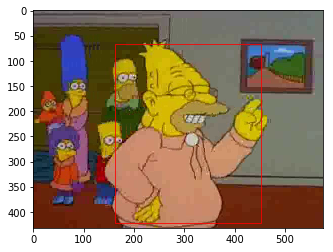

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

#     preview what the bounding box looks like
i = 44

img_path = image_paths[i]
x0,y0,x1,y1 = bounding_box[i]

image = np.array(Image.open(img_path))

# draw the image
fig, ax1 = plt.subplots(1)
p = plt.imshow(image)

# draw the bounding boxes
upleft = (x0, y0)
width = x1-x0
height = y1-y0
rect = patches.Rectangle(upleft, width, height, linewidth=0.8, edgecolor='r', facecolor='none')
ax1.add_patch(rect) 

plt.show()

In [9]:
import os

# loop through all images
for i in range(len(image_paths)):
    
#     use PIL package to crop the image
    img_path = image_paths[i]
    im = Image.open(img_path)
    x0,y0,x1,y1 = bounding_box[i]
    region = im.crop((x0,y0,x1,y1))
    
#     create new directories and store the images there
    directory = 'D:/DKU-course/STATS/302 Principles of Machine Learning/homework/final/data/characters_cropped/'+image_paths[i].split('/')[-2]
    if not os.path.exists(directory):
        os.makedirs(directory)
    region.save(directory+'/'+image_paths[i].split('/')[-1])

## Manually split out test data

After finding that our testd data is included in the training data, we decided to write a program to split our original training data. That way 
we can have new training and testing dataset with no overlapping.

In [11]:
import shutil
import pathlib
import os
from os import path

# the folder we want to split
file_path = 'D:\\DKU-course\\STATS\\302 Principles of Machine Learning\\homework\\final\\data\\20characters'

char_paths = []
chars_image_paths = {}

# record all the sub-directory of the parent folder 
for root, subdir, files in os.walk(file_path):
        char_paths.append(root)
char_paths = char_paths[1:]

# record all the images under sub-directories
for i in range(len(char_paths)):
    char = char_paths[i].split('\\')[-1]
    cur_path = pathlib.Path('D:\\DKU-course\\STATS\\302 Principles of Machine Learning\\homework\\final\\data\\20characters\\' + char) 
    image_paths = list(cur_path.glob('*.jpg'))
    image_paths = [str(path) for path in image_paths]
    chars_image_paths[char] = image_paths

In [12]:
import random

# train/test split rate
ratio = 0.1
# the output path
output_path = 'D:\\DKU-course\\STATS\\302 Principles of Machine Learning\\homework\\final\\data\\20characters_test\\'

# shuffle the orginal data
for y in chars_image_paths.values():
    random.shuffle(y)

# move the test data into the new directory
for i in range(len(char_paths)):
    char = char_paths[i].split('\\')[-1]
    num_images = len(chars_image_paths[char])
    moves = round(num_images * ratio)
    
    if not os.path.exists(output_path + char):
        os.makedirs(output_path + char)
    
    for j in range(moves):
        shutil.move(chars_image_paths[char][j], 
                    output_path + char)

·Because the cropping and spliting are all processes directly operating on the original folder containing images, we didn't provide the data here.

## Pick the 20 characters 

When testing, we found that not all 42 characters in training data are included in test data. In fact, the test dataset the author provides only includes 20 characters.
To avoid misclassfication, we decided to pick the corresponding 20 characters out as our new training data.

However, later we found that test data is actually included in the training data, which means it can't be used as test data. Fortunately, the 20 
characters in test data are also characters whose number of images are top 20. So still, the training data with 20 characters can be used to 
reduce the imblance in data by diacarding those characters whose data is small. We will just build a model whose output has 20 classes.

In [32]:
def create_20_char_data(train_data, train_label, test_data, test_label):
    # first create a dictionary that maps original labels (0-41) to new label (0-19) in ascending order
    new_label = {}
    cnt = 0
    for i in np.unique(test_label):
        new_label[i] = cnt
        cnt+=1
    X_train_20_char = []
    y_train_20_char = []
    X_test_20_char = test_data
    y_test_20_char = []
    for i in range(len(train_label)):
        if train_label[i] in test_label:
            # append training data if data is one of the 20 chars
            X_train_20_char.append(train_data[i])
            # append training label if label is one of the 20 chars, within the range of 20
            y_train_20_char.append(new_label[train_label[i]])
            
    for j in range(990):
        y_test_20_char.append(new_label[test_label[j]])
        
    np.save('X_train_20_char', X_train_20_char)
    np.save('y_train_20_char', y_train_20_char)
    np.save('X_test_20_char', X_test_20_char)
    np.save('y_test_20_char', y_test_20_char)

##  Convert RGB into grayscale

To see how is our model learning features of characters. Does it classify by certain shape of the object or by the composition of colors? We convert
the RGB image ito grayscale to how is our model doing.

In [38]:
def rgb2gray(train_data,test_data):
#     The input consists of rgb images with shape (height,width,3), 
#         and the rgb weights array is given by standard ITU-R 601-2 luma transform.
        X_train_20_char_gray = np.dot(train_data, [0.2989, 0.5870, 0.1140]) 
        X_test_20_char_gray = np.dot(test_data, [0.2989, 0.5870, 0.1140])
        
        np.save('X_train_20_char_gray', X_train_20_char_gray)
        np.save('X_test_20_char_gray', X_test_20_char_gray)